In [6]:
import os

# --- Add these lines at the very top of your script ---
# This must be done BEFORE importing numpy or other scientific libraries.
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import product
import time
from device import Device
from device import Device
from rgf import GreensFunction
import scipy as sp
from hamiltonian import Hamiltonian
from helper import Helper_functions
import scipy.sparse as spa
import numpy as np
import scipy.sparse as sp
from lead_self_energy import LeadSelfEnergy
from scipy.sparse import bmat, identity, random, csc_matrix
from scipy.sparse.linalg import eigsh, eigs, spsolve
import time
from NEGF_unit_generation import UnitCell





from device import Device
from hamiltonian import Hamiltonian

from typing import Tuple

def GzerozeroH_W_sparse(wmH: sp.spmatrix, t: sp.spmatrix) -> np.ndarray:
    """
    Surface Green's function calculation optimized for sparse matrices.
    """
    N = wmH.shape[0]
    

    wmH_dense = wmH.toarray()
    t_dense = t.toarray()

    A = np.zeros((2*N, 2*N), dtype=complex)
    B = np.zeros((2*N, 2*N), dtype=complex)
    
    A[:N, N:2*N] = np.eye(N)
    A[N:2*N, :N] = -t_dense.conj().T
    A[N:2*N, N:2*N] = wmH_dense
    
    B[:N, :N] = np.eye(N)
    B[N:2*N, N:2*N] = t_dense
    

    try:
        eigenvalues, eigenvectors = linalg.eig(A, B)
    except linalg.LinAlgError:
        print("Warning: Using pseudo-inverse for eigenvalue problem")
        B_pinv = linalg.pinv(B)
        eigenvalues, eigenvectors = linalg.eig(B_pinv @ A)
    

    magnitudes = np.abs(eigenvalues)

    valid_mask = np.isfinite(magnitudes) & (magnitudes > 1e-12)
    valid_eigenvalues = eigenvalues[valid_mask]
    valid_eigenvectors = eigenvectors[:, valid_mask]
    valid_magnitudes = magnitudes[valid_mask]
    
    if len(valid_eigenvalues) == 0:
        raise ValueError("No valid eigenvalues found")
    

    real_parts = np.real(valid_eigenvalues)
    sorted_indices = np.lexsort((valid_magnitudes, real_parts))
    
 
    sorted_eigenvectors = valid_eigenvectors[:, sorted_indices]
    
    Z11 = sorted_eigenvectors[:N, :N]
    Z21 = sorted_eigenvectors[N:2*N, :N]
    

    Z11_inv = linalg.pinv(Z11, rtol=1e-12)
    Gzeta = Z21 @ Z11_inv

    
    return Gzeta
def self_energy(side, E, ky, ham: Hamiltonian) -> np.ndarray:
    """
    Corrected self-energy calculation.
    """
    H00, H01, H10 = ham.get_H00_H01_H10(ky, side=side, sparse=True)
    
    N = H00.shape[0]
    eta = 1e-6
    wmH = E * sp.eye(N, dtype=complex) - H00 + 1j * eta * sp.eye(N, dtype=complex)
    
    if side == "left":
        
        Gzeta = GzerozeroH_W_sparse(wmH, H10)

        selfenergy = H10.toarray() @ Gzeta @ H10.conj().T.toarray()
    else:
        Gzeta = GzerozeroH_W_sparse(wmH, H01)
        selfenergy = H01.toarray() @ Gzeta @ H01.conj().T.toarray()
    
    return selfenergy
    
    
def calculate_self_energy_nanowire(H00: sp.spmatrix, H01: sp.spmatrix, 
                                  E: float, eta: float = 1e-6) -> np.ndarray:
    """
    Calculate self-energy for silicon nanowire system.
    
    Parameters:
    -----------
    H00 : sp.spmatrix
        Unit cell Hamiltonian (sparse)
    H01 : sp.spmatrix
        Coupling between unit cells (sparse)
    E : float
        Energy
    eta : float
        Small imaginary part
        
    Returns:
    --------
    np.ndarray
        Self-energy matrix
    """
    N = H00.shape[0]
    
    wmH = E * sp.eye(N, dtype=complex) - H00 + 1j * eta * sp.eye(N, dtype=complex)
    
    print(f"Energy E = {E}")
    print(f"Matrix size N = {N}")
    print(f"wmH shape: {wmH.shape}")
    print(f"H01 shape: {H01.shape}")
    
    wmH_dense = wmH.toarray()
    H01_dense = H01.toarray()
    
    print(f"wmH trace: {np.trace(wmH_dense):.6f}")
    print(f"H01 trace: {np.trace(H01_dense):.6f}")
    print(f"wmH norm: {np.linalg.norm(wmH_dense):.6f}")
    print(f"H01 norm: {np.linalg.norm(H01_dense):.6f}")
    
    if np.allclose(wmH_dense, 0):
        print("WARNING: wmH is zero!")
        return np.zeros((N, N), dtype=complex)
    
    if np.allclose(H01_dense, 0):
        print("WARNING: H01 is zero!")
        return np.zeros((N, N), dtype=complex)
    
    Gzeta = GzerozeroH_W_sparse(wmH, H01)
    selfenergy = H01_dense @ Gzeta @ H01_dense.conj().T
    
    print(f"Self-energy trace: {np.trace(selfenergy):.6f}")
    print(f"Self-energy norm: {np.linalg.norm(selfenergy):.6f}")
    
    return selfenergy

def dos_value(E, ky, ham : Hamiltonian):
    unitCell = UnitCell(ham.device.unitZ, ham.device.unitX, not_NEGF=True)
    H = ham.create_sparse_channel_hamlitonian(ky, unitCell = unitCell, blocks=False)
    N = H.shape[0]
    I = sp.eye(N, dtype=complex)
    # H[-ham.Nz * 10:,-ham.Nz * 10:] += sp.csc_matrix(self_energy("right", E, ky, ham=ham)[-ham.Nz * 10:,-ham.Nz * 10:])
    # H [:ham.Nz * 10,:ham.Nz * 10]+= sp.csc_matrix(self_energy("left", E, ky, ham=ham)[:ham.Nz * 10,:ham.Nz * 10])
    H_bar = (E + 1j * 1e-6) * I - H
    
    GR = spla.spsolve(H_bar, I)
    
    return - 1 / np.pi * np.imag(GR.trace())
    

In [3]:
import numpy as np
from scipy import linalg
from typing import Tuple, List

def selfH_new_from_layers(E: float, layers: dict, N: int, lead: str, eta: float = 1e-6) -> np.ndarray:
    """
    Calculate self-energy using your layer-based Hamiltonian.
    
    Parameters:
    -----------
    E : float
        Energy
    layers : dict
        Output from getLayersHamiltonian method
    N : int
        Block size (number of orbitals per layer)
    lead : str
        "left" or "right"
    eta : float
        Small imaginary part
        
    Returns:
    --------
    np.ndarray
        Self-energy matrix
    """
    
    wmH = np.zeros((4*N, 4*N), dtype=complex)
    P = np.zeros((4*N, 4*N), dtype=complex)
    
    # Extract diagonal and coupling matrices from your layers
    diag_blocks = []
    updiag_blocks = []
    
    for layer in range(4):
        H_pp, H_p_p1 = layers[layer]
        diag_blocks.append(H_pp.toarray() if hasattr(H_pp, 'toarray') else H_pp)
        
        if H_p_p1 is not None:
            updiag_blocks.append(H_p_p1.toarray() if hasattr(H_p_p1, 'toarray') else H_p_p1)
        else:
            # For the last layer, create zero coupling (will be handled by periodic BC)
            updiag_blocks.append(np.zeros((N, N), dtype=complex))
    
    if lead == "left":
        # Construct wmH matrix for left lead
        for k in range(3):
            for i in range(N):
                for j in range(N):
                    if i == j:
                        wmH[j+k*N, j+k*N] = E + diag_blocks[k][j, j] + 1j*eta
                    else:
                        wmH[i+k*N, j+k*N] = diag_blocks[k][i, j]
        
        # Upper diagonal blocks (forward coupling)
        for k in range(3):
            for i in range(N):
                for j in range(N):
                    wmH[i+k*N, j+(k+1)*N] = updiag_blocks[k][i, j]
        
        # Lower diagonal blocks (backward coupling = Hermitian conjugate)
        for k in range(1, 3):
            for i in range(N):
                for j in range(N):
                    wmH[i+k*N, j+(k-1)*N] = updiag_blocks[k-1][j, i].conj()
        
        # T-10 element (periodic boundary - coupling from layer 3 to layer 0)
        # This should be the coupling from the last layer back to the first
        # You might need to adjust this based on your specific periodic boundary
        for i in range(N):
            for j in range(N):
                wmH[i+3*N, j] = updiag_blocks[3][i, j]  # H_30 coupling
        
        # P matrix construction
        for i in range(N):
            for j in range(N):
                P[i, j+3*N] = -updiag_blocks[3][j, i].conj()  # -H_03^†
                P[i+3*N, j+2*N] = -updiag_blocks[2][j, i].conj()  # -H_32^†
                if i == j:
                    P[i+3*N, j+3*N] = -(E + diag_blocks[3][i, j] + 1j*eta)
                else:
                    P[i+3*N, j+3*N] = -diag_blocks[3][i, j]
    
    else:  # Right lead
        # Similar construction for right lead
        for k in range(4):
            for i in range(N):
                for j in range(N):
                    if i == j:
                        wmH[j+k*N, j+k*N] = E + diag_blocks[k][j, j] + 1j*eta
                    else:
                        wmH[i+k*N, j+k*N] = diag_blocks[k][i, j]
        
        # Upper diagonal blocks
        for k in range(3):
            for i in range(N):
                for j in range(N):
                    wmH[i+k*N, j+(k+1)*N] = updiag_blocks[k][i, j]
        
        # Lower diagonal blocks
        for k in range(1, 4):
            for i in range(N):
                for j in range(N):
                    wmH[i+k*N, j+(k-1)*N] = updiag_blocks[k-1][j, i].conj()
        
        # Periodic boundary conditions
        for i in range(N):
            for j in range(N):
                wmH[i+3*N, j] = updiag_blocks[3][i, j]  # H_30
                wmH[i, j+3*N] = updiag_blocks[0][j, i].conj()  # H_03^†
        
        # Flip matrix for right lead
        wmH = np.flipud(np.fliplr(wmH))
        
        # Construct P matrix from flipped wmH
        for i in range(N):
            for j in range(N):
                P[i, j+3*N] = -wmH[i, j+3*N]
                P[3*N+i, 2*N+j] = -wmH[3*N+i, 2*N+j]
                P[3*N+i, 3*N+j] = -wmH[3*N+i, 3*N+j]
        
        # Zero out unnecessary blocks
        for i in range(2*N):
            for j in range(N):
                wmH[i, 3*N+j] = 0
                wmH[3*N+j, 2*N+i] = 0
    
    # Rest of the algorithm (same as before)
    t = wmH[3*N:4*N, 0:N].copy()
    temp = wmH - P
    temp_inv = linalg.inv(temp)
    temp = temp_inv @ P
    temp_min = temp[2*N:4*N, 2*N:4*N].copy()
    
    # Eigenvalue decomposition and mode classification
    eigenvalues, eigenvectors = linalg.eig(temp_min)
    
    # Compute lambda values and classify modes
    ld = np.zeros(2*N, dtype=complex)
    flag_right = np.zeros(2*N, dtype=int)
    
    for i in range(2*N):
        # Compute lambda from eigenvalues
        den = np.abs(1 + eigenvalues[i])**2
        ld[i] = (eigenvalues[i] + np.abs(eigenvalues[i])**2) / den
        
        # Classify as left-moving (|lambda| < 1) or right-moving (|lambda| >= 1)
        if np.abs(ld[i]) < 1:
            flag_right[i] = 1  # Left-moving
        else:
            flag_right[i] = 0  # Right-moving
    
    # Compute w01 matrix
    temp_min = temp[0:2*N, 2*N:4*N].copy()
    LAMBDA = np.diag(-eigenvalues / np.abs(eigenvalues)**2)
    w01 = temp_min @ eigenvectors @ LAMBDA
    
    # Construct MM matrix from left-moving modes
    MM = np.zeros((N, N), dtype=complex)
    k = 0
    for i in range(2*N):
        if flag_right[i] == 1:  # Left-moving electrons
            MM[k, :] = eigenvectors[N:2*N, i]
            k += 1
    
    # Handle rank deficiency by filling with canonical vectors
    rankR = N
    rankC = N
    index_zero_row = np.zeros(N, dtype=int)
    index_zero_column = np.zeros(N, dtype=int)
    
    for i in range(N):
        # Check rows
        if np.sum(np.abs(MM[i, :])) <= eta:
            rankR -= 1
            index_zero_row[i] = 1
        
        # Check columns  
        if np.sum(np.abs(MM[:, i])) <= eta:
            rankC -= 1
            index_zero_column[i] = 1
    
    rank = min(rankR, rankC)
    
    # Fill MM matrix with canonical vectors if needed
    if rank < N:
        if rankR == N:
            for j in range(N):
                if index_zero_column[j] == 1:
                    for i in range(N-rankC):
                        if i == (j-rankC):
                            MM[i+rankC, j] = 1.0
                        else:
                            MM[i+rankC, j] = 0.0
        else:
            incr = 0
            for j in range(N):
                if index_zero_column[j] == 1:
                    while index_zero_row[incr] != 1:
                        incr += 1
                    for i in range(N):
                        if i == incr:
                            MM[i, j] = 1.0
                        else:
                            MM[i, j] = 0.0
                    incr += 1
    
    # Invert MM matrix
    MM_inv = linalg.inv(MM)
    
    # Compute final self-energy
    temp2 = np.zeros((N, N), dtype=complex)
    
    for ncomp in range(N):
        b = np.zeros(N, dtype=complex)
        kk = 0
        for i in range(2*N):
            if flag_right[i] == 1:  # Left-moving electrons
                b[kk] = ld[i] * w01[ncomp, i]
                kk += 1
        
        v = MM_inv @ b
        temp2[ncomp, :] = v
    
    # Final self-energy calculation
    selfenergy = t @ temp2
    
    # Flip matrix for right lead
    if lead == 0:
        selfenergy = np.flipud(np.fliplr(selfenergy))
    
    return selfenergy

def calculate_self_energy_with_layers(E: float, ham: Hamiltonian, ky: float, 
                                     side: str, eta: float = 1e-6) -> np.ndarray:
    """
    Calculate self-energy using your layer-based approach.
    """
    # Get layer Hamiltonians
    layers = ham.getLayersHamiltonian(ky, side=side)
    
    # Get block size from first layer
    N = layers[0][0].shape[0] if hasattr(layers[0][0], 'shape') else layers[0][0].toarray().shape[0]
    
    return selfH_new_from_layers(E, layers, N, side, eta)

In [5]:
dev = Device(channel_length=2.15e-9, channel_thickness=1.5e-9)
ham = Hamiltonian(dev)
self_energy = calculate_self_energy_with_layers(E=0, ky=0, ham=ham,side='left')



In [6]:
self_energy.shape

(60, 60)

In [7]:
from lead_self_energy import LeadSelfEnergy


lse = LeadSelfEnergy(device=dev, hamiltonian=ham)
sl = lse.self_energy("left", E=0, ky=0)
sl.shape


(30, 30)

Starting DOS calculations for 1250 (E, ky) pairs...
Energy range: -2.00 to 3.00 eV
ky range: 0.00 to 1.00


/home/nandan_diwan/Desktop/NEGF_sim/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/nandan_diwan/Desktop/NEGF_sim/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/nandan_diwan/Desktop/NEGF_sim/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/nandan_diwan/Desktop/NEGF_sim/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j,

Calculations finished in 17.82 seconds.
Valid results: 1250/1250
DOS calculation complete. Energy points: 50


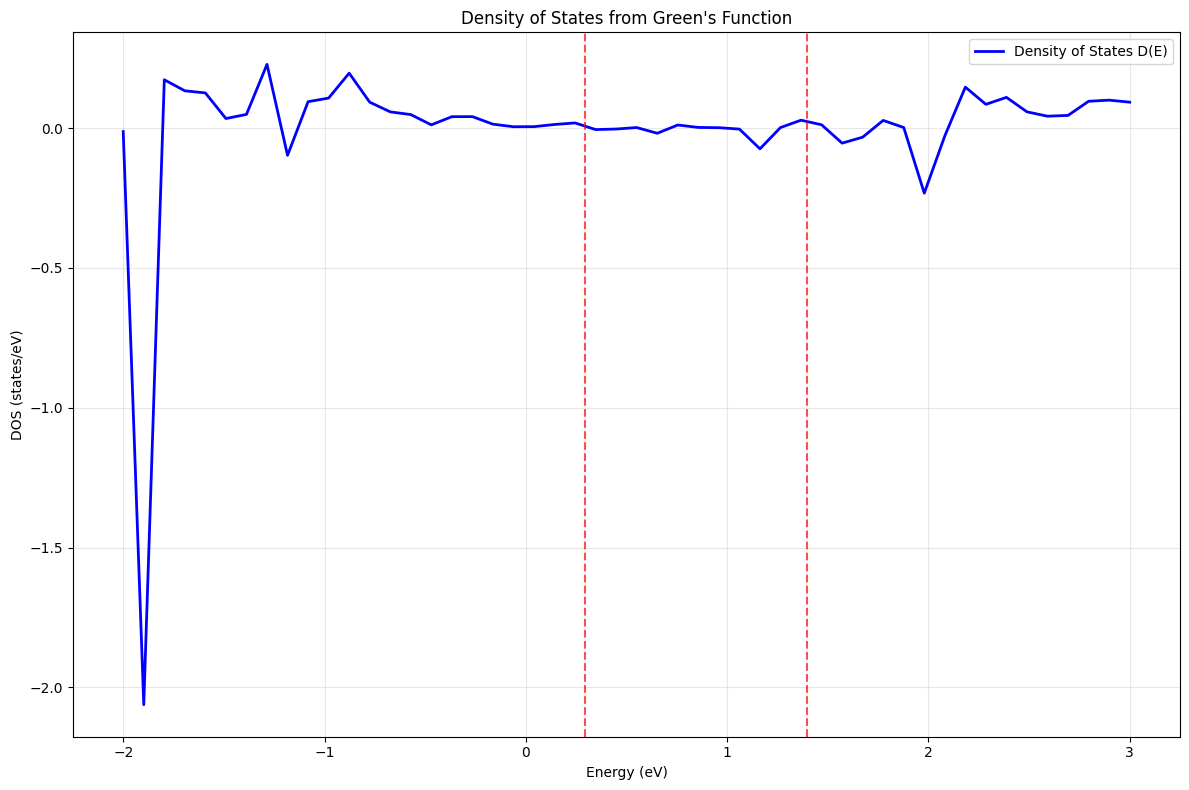

In [7]:
def DOS(param): 
    E, ky = param
    eta = 1e-6  # Small broadening parameter for numerical stability
    
    dev = Device(2e-9, 1e-9)
    ham = Hamiltonian(dev)
    lse = LeadSelfEnergy(device=dev, hamiltonian=ham)
    #unit_cell = UnitCell(dev.unitZ, dev.unitX, orientiation=(0, 1, 2, 3), not_NEGF=True)
    
    H = ham.create_sparse_channel_hamlitonian(ky, blocks=False)
    sl, sr = lse.self_energy("left", E=E, ky=ky), lse.self_energy("right", E=E, ky=ky)
    H[:ham.Nz * 10*2, :ham.Nz * 10*2] += sl
    H[-ham.Nz * 10*2:, -ham.Nz * 10*2:] += sr
    # Add small imaginary part to energy
    E_complex = E + 1j * eta
    
    # Construct Green's function: G(E) = (E*I - H)^(-1)
    H_gf = csc_matrix(np.eye(H.shape[0], dtype=complex) * E_complex) - H
    I = csc_matrix(np.eye(H.shape[0], dtype=complex))
    
    # Solve for Green's function
    G_R = spsolve(H_gf, I)
    
    # DOS = -(1/π) * Im[Tr(G_R(E))]
    dos = -1/np.pi * np.imag(G_R.trace())
    
    return (E, ky, dos)

# Use a wider energy range to capture the full band structure
energy_values = np.linspace(-2, 3, 50)  # Wider range, more points
ky_values = np.linspace(0, 1.0, 25)     # More ky points for better k-space sampling
dk = ky_values[1] - ky_values[0]

param_grid = list(product(energy_values, ky_values))

print(f"Starting DOS calculations for {len(param_grid)} (E, ky) pairs...")
print(f"Energy range: {energy_values[0]:.2f} to {energy_values[-1]:.2f} eV")
print(f"ky range: {ky_values[0]:.2f} to {ky_values[-1]:.2f}")

start_time = time.time()

with multiprocessing.Pool(processes=64) as pool:
    results = pool.map(DOS, param_grid)
    
end_time = time.time()
print(f"Calculations finished in {end_time - start_time:.2f} seconds.")

# Aggregate traces for each energy value (sum over all ky values)
energy_traces = defaultdict(float)
valid_results = 0

for energy, ky, dos_val in results:
    if not (np.isnan(dos_val) or np.isinf(dos_val)):
        energy_traces[energy] += dos_val
        valid_results += 1
    else:
        print(f"Invalid result at E={energy:.3f}, ky={ky:.3f}: {dos_val}")

print(f"Valid results: {valid_results}/{len(results)}")

# Sort energies and calculate final DOS
dos_energies = sorted(energy_traces.keys())

# For 2D system, multiply by k-space integration factor
# The factor dk/(2π) accounts for the k-space sampling
dos_values = []
for E in dos_energies:
    dos_val = energy_traces[E] * (dk / (2 * np.pi))
    dos_values.append(dos_val)

print(f"DOS calculation complete. Energy points: {len(dos_energies)}")

# Plotting the Density of States
plt.figure(figsize=(12, 8))

plt.plot(dos_energies, dos_values, 'b-', linewidth=2, label='Density of States D(E)')
plt.xlabel('Energy (eV)')
plt.ylabel('DOS (states/eV)')
plt.title('Density of States from Green\'s Function')
plt.grid(True, alpha=0.3)
plt.legend()

# Add vertical lines to show bandgap
plt.axvline(x=0.296, color='r', linestyle='--', alpha=0.7, label='Band edge')
plt.axvline(x=1.396, color='r', linestyle='--', alpha=0.7, label='Band edge')

plt.tight_layout()
plt.savefig("dos.png", dpi=300, bbox_inches='tight')
plt.show()

# Save data for further analysis
np.savetxt("dos_data.txt", np.column_stack([dos_energies, dos_values]), 
            header="Energy(eV)\tDOS(states/eV)", fmt="%.6e")

In [ ]:
import multiprocessing as mp
from functools import partial
import warnings
import warnings

def dos_worker(args):
    """Worker function that can be pickled"""
    E, ky, dev_params, ham_params = args
    
    # Suppress warnings in worker processes
    warnings.filterwarnings('ignore')
    
    # Recreate device and hamiltonian objects in worker process
    local_dev = Device(channel_length=dev_params['channel_length'], 
                      channel_thickness=dev_params['channel_thickness'])
    local_ham = Hamiltonian(local_dev)
    
    return dos_value(E, ky, local_ham)

def dos_integrated_parallel(E, num_processes=None):
    """Calculate DOS at energy E by integrating over ky from 0 to 1 using multiprocessing"""
    # Suppress warnings in main process
    warnings.filterwarnings('ignore')
    
    if num_processes is None:
        num_processes = mp.cpu_count()
    
    # Get device parameters to pass to workers
    dev_params = {
        'channel_length': dev.channel_length,
        'channel_thickness': dev.channel_thickness
    }
    ham_params = {}  # Add any hamiltonian parameters if needed
    
    # Define integration points
    n_points = 100  # Adjust based on desired accuracy
    ky_points = np.linspace(0, 1, n_points)
    
    # Create argument tuples for worker function
    args_list = [(E, ky, dev_params, ham_params) for ky in ky_points]
    
    # Use multiprocessing to evaluate DOS at all ky points
    with mp.Pool(processes=num_processes) as pool:
        dos_values = pool.map(dos_worker, args_list)
    
    # Take absolute value to ensure positive DOS and integrate using trapezoidal rule
    dos_values = np.abs(dos_values)
    result = np.trapz(dos_values, ky_points)
    return result

# Example: Calculate DOS at a specific energy
E_test = 0
dos_result = dos_integrated_parallel(E_test)
print(f"DOS at E = {E_test} (parallel): {dos_result}")

In [ ]:
E = np.linspace()